## 1. Get discrete trajectories to work with

In [1]:
from msmbuilder.example_datasets import AlanineDipeptide
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trajs = AlanineDipeptide().get().trajectories

from msmbuilder.featurizer import DihedralFeaturizer,AtomPairsFeaturizer
n_atoms=trajs[0].n_atoms
pairs = []
for i in range(n_atoms):
    for j in range(i):
        pairs.append((i,j))
apf = AtomPairsFeaturizer(pairs)
dih = DihedralFeaturizer()

X_apf = apf.fit_transform(trajs)
X_dih = apf.fit_transform(trajs)

X = [np.hstack([X_apf[i],X_dih[i]]) for i in range(len(trajs))]

In [3]:
import pyemma
tica = pyemma.coordinates.tica(X)
X_tica = tica.get_output()

kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=100,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

kmeans iterations:  17% ( 177/1000) [#####                         ] eta 00:38 /11-05-16 08:31:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[1] INFO     Cluster centers converged after 178 steps.
getting output of MiniBatchKmeansClustering: 100% (20/20) [########] eta 00:01 |

## 2. "Milestone" our trajectories

In [4]:
def milestone(dtrajs,milestoning_set):
    milestoned_dtrajs = []
    for dtraj in dtrajs:
        milestoned_traj = np.zeros(len(dtraj),dtype=int)

        last_milestone_visited = -1
        for i in range(len(dtraj)):

            if dtraj[i] in milestoning_set:
                last_milestone_visited = dtraj[i]

            milestoned_traj[i] = last_milestone_visited
        milestoned_dtrajs.append(milestoned_traj+1)
    return milestoned_dtrajs

In [5]:
# choose random milestones
np.random.seed(0)
milestones = np.random.randint(0,100,10)
dtrajs_m = milestone(dtrajs,milestones)

In [6]:
dtrajs_m

[array([ 0,  0,  0, ..., 68, 68, 68]),
 array([ 0,  0,  0, ..., 37, 37, 37]),
 array([ 0,  0,  0, ..., 84, 84, 84]),
 array([ 0,  0,  0, ..., 45, 45, 45]),
 array([ 0,  0,  0, ..., 22, 22, 22]),
 array([ 0,  0,  0, ..., 22, 22, 22]),
 array([ 0,  0,  0, ..., 37, 37, 37]),
 array([ 0,  0,  0, ..., 65, 65, 65]),
 array([ 0,  0,  0, ..., 88, 88, 88]),
 array([ 0,  0,  0, ..., 68, 68, 68])]

## 2.1. Compare ITS of trajectories before / after milestoning

estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:00 -11-05-16 08:31:36 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Changed user setting nits to the number of available timescales nits=8


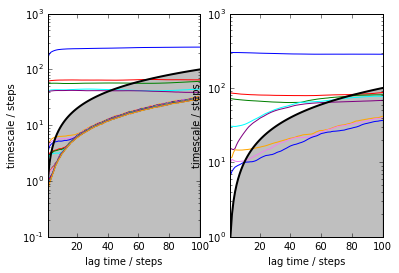

In [7]:
lags = range(1,101)
its_0 = pyemma.msm.its(dtrajs,lags=lags,nits=20)
its_1 = pyemma.msm.its(dtrajs_m,lags=lags,nits=20)

plt.subplot(1,2,1)
pyemma.plots.plot_implied_timescales(its_0)
plt.subplot(1,2,2)
pyemma.plots.plot_implied_timescales(its_1)

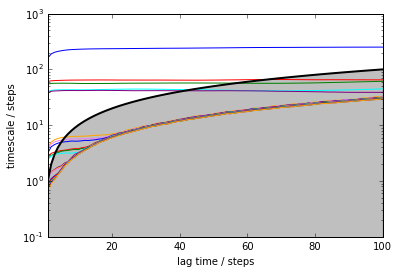

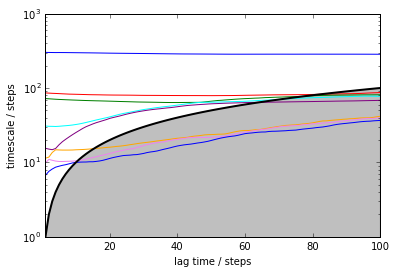

In [8]:
pyemma.plots.plot_implied_timescales(its_0)
plt.figure()
pyemma.plots.plot_implied_timescales(its_1)

## 2.2. Also build and inspect MSMs built using these milestones

In [9]:
lag=1
msm_0 = pyemma.msm.estimate_markov_model(dtrajs,lag=lag)
msm_1 = pyemma.msm.estimate_markov_model(dtrajs_m,lag=lag)

In [10]:
msm_0.active_count_fraction,msm_1.active_count_fraction

(1.0, 0.988759887598876)

In [11]:
sum(msm_0.eigenvalues()),sum(msm_0.eigenvalues())/len(msm_0.transition_matrix)

(15.196621990289177, 0.15196621990289177)

In [12]:
sum(msm_1.eigenvalues()),sum(msm_1.eigenvalues())/len(msm_1.transition_matrix)

(8.5578247381822834, 0.95086941535358704)

## 3. Key steps in paper:
- Form a matrix $\Gamma$, counting intermediate hitting events
- Write down an objective function $\rho(\mathcal{M} | \Gamma)$
- Approximately minimize that objective function

Question: does that objective function (eqn. 4 in the paper) make sense / correlate with the metastability of the resulting MSM?

## 3.1. Form $\Gamma$

$$\Gamma_{ij}\equiv \frac{N_{ij}}{N_i}$$

where $N_i$ and $N_{ij}$ are formed as follows.

Given a trajectory $(i,k,i,j,k,j,i,k,j)$, we break into pieces that start with $i$ and and contain all the indices until $i$ is visited again:
1. $(i,k)$
2. $(i,j,k,j)$
3. $(i,k,j)$

$N_{ij}$ is then the number of pieces that contain $j$ at least once, and $N_i$ is the number of pieces.

In [13]:
def form_gamma(dtrajs):
    dtraj_stack = np.hstack(dtrajs)
    n_states = len(set(dtraj_stack))
    
    gamma = np.zeros((n_states,n_states))
    
    for dtraj in dtrajs:
        for i in range(n_states):
            indices = list(np.arange(len(dtraj))[dtraj==i]) + [len(dtraj)]
            for t in range(len(indices)-1):
                js = set(dtraj[indices[t]:indices[t+1]])
                for j in js - set([i]):
                    gamma[i,j] += 1
        
    for i in range(n_states):
        gamma[i] /= np.sum(dtraj_stack==i)
    
    return gamma

In [14]:
gamma = form_gamma(dtrajs)

In [15]:
gamma

array([[ 0.        ,  0.29446064,  0.13702624, ...,  0.26530612,
         0.16618076,  0.28862974],
       [ 0.05942275,  0.        ,  0.02999434, ...,  0.04301075,
         0.03848331,  0.19298246],
       [ 0.10891089,  0.12623762,  0.        , ...,  0.09158416,
         0.2450495 ,  0.11881188],
       ..., 
       [ 0.63888889,  0.52083333,  0.28472222, ...,  0.        ,
         0.33333333,  0.52777778],
       [ 0.0381016 ,  0.0434492 ,  0.06617647, ...,  0.03074866,
         0.        ,  0.0407754 ],
       [ 0.06397516,  0.21490683,  0.03167702, ...,  0.0484472 ,
         0.04037267,  0.        ]])

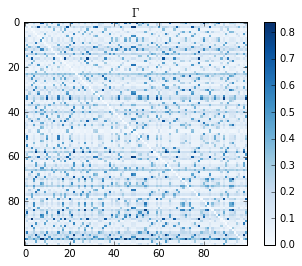

In [16]:
plt.imshow(gamma,interpolation='none',cmap='Blues')
plt.colorbar()
plt.title(r'$\Gamma$')

## 3.2. Write down "metastability index" objective function, $\rho_\mathcal{M}$
$$\rho_\mathcal{M} \equiv \rho(\mathcal{M} \; | \; \Gamma) = \frac{\max_{i \in \mathcal{M}} \left( \max_{j \in \mathcal{M}\setminus \{i\}} \Gamma_{ij} \right)}
{\min_{i \not\in \mathcal{M}} \left( \max_{j \in \mathcal{M}} \Gamma_{ij} \right)}$$

In [17]:
def metastability_index(gamma,M):
    numerator = 0
    for i in M:
        # maximize over i
        Mprime = set(M) - set([i])
        for j in Mprime:
            # maximize over j
            if gamma[i,j] > numerator:
                numerator = gamma[i,j]
    
    denominators = []
    for i in set(range(len(gamma))) - set(M):
        
        # maximize over j
        denominator = 0
        for j in M:
            if gamma[i,j] > denominator:
                denominator = gamma[i,j]
        
        denominators.append(denominator)
    
    #minimize over i
    denominator = min(denominators)
    
    return numerator / denominator

In [18]:
metastability_index(gamma,milestones)

7.3763887322355055

## 4. Does this "metastability index" correlate with the metastability of the resulting MSM?

In [19]:
np.random.seed(0)

def sample_random_milestone_sets(n_milestones,n_states=100,n_samples=100):

    indices = np.arange(n_states)
    msms = []
    metastability_indices = []

    for i in range(n_samples):
        np.random.shuffle(indices)
        milestones = indices[:n_milestones]
        dtrajs_m = milestone(dtrajs,milestones)
        msm_1 = pyemma.msm.estimate_markov_model(dtrajs_m,lag=lag)

        msms.append(msm_1)
        metastability_indices.append(metastability_index(gamma,milestones))
    return msms,metastability_indices

## 4.1. For fixed `n_milestones=5`

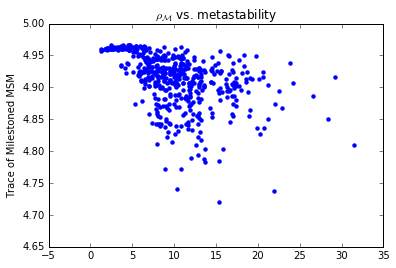

In [20]:
msms,metastability_indices = sample_random_milestone_sets(5,n_states=100,n_samples=500)
msm_metastability = [np.trace(msm.transition_matrix) for msm in msms]
plt.scatter(metastability_indices,msm_metastability,linewidths=0)
plt.ylabel('Trace of Milestoned MSM')
plt.title(r'$\rho_\mathcal{M}$ vs. metastability')

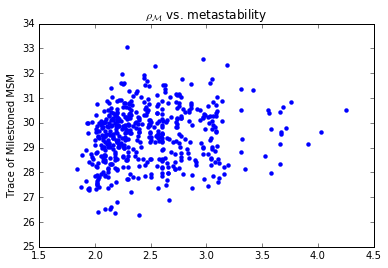

In [21]:
msms,metastability_indices = sample_random_milestone_sets(50,n_states=100,n_samples=500)
msm_metastability = [np.trace(msm.transition_matrix) for msm in msms]
plt.scatter(metastability_indices,msm_metastability,linewidths=0)
plt.ylabel('Trace of Milestoned MSM')
plt.title(r'$\rho_\mathcal{M}$ vs. metastability')

## 4.2. For a range of `n_milestones`

In [22]:
results = []
Ms = [5,10,15] # various n_milestones
n_samples = 500 # number of samples at for each n_milestones
for M in Ms:
    result = sample_random_milestone_sets(M,n_states=100,n_samples=n_samples)
    results.append(result)

In [23]:
# coloring by the number of milestones
colors = np.zeros(len(Ms)*n_samples)
for i in range(len(Ms)):
    colors[i*n_samples:(i+1)*n_samples] = Ms[i]

In [24]:
metastability_indices = np.hstack([r[1] for r in results])

In [25]:
msms = []
for r in results:
    msms += r[0]
msm_metastability = [np.trace(msm.transition_matrix) for msm in msms]

In [26]:
np.mean(msm_metastability),np.std(msm_metastability)

(9.2727435247669998, 3.5061966752224469)

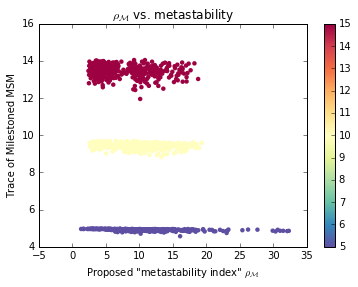

In [27]:
plt.scatter(metastability_indices,msm_metastability,c=colors,linewidths=0,cmap='Spectral_r')
plt.xlabel(r'Proposed "metastability index" $\rho_\mathcal{M}$')
plt.ylabel('Trace of Milestoned MSM')
plt.title(r'$\rho_\mathcal{M}$ vs. metastability')
plt.colorbar()

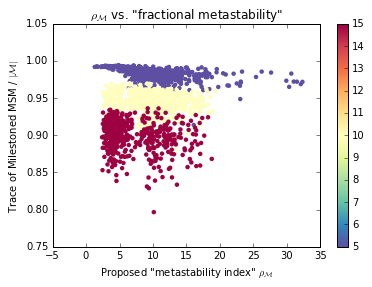

In [28]:
plt.scatter(metastability_indices,msm_metastability/colors,c=colors,linewidths=0,cmap='Spectral_r')
plt.xlabel(r'Proposed "metastability index" $\rho_\mathcal{M}$')
plt.ylabel(r'Trace of Milestoned MSM / $|\mathcal{M}|$')
plt.title(r'$\rho_\mathcal{M}$ vs. "fractional metastability"')
plt.colorbar()

## 4.3. For a bigger range of `n_milestones`

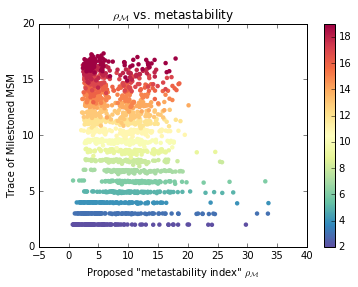

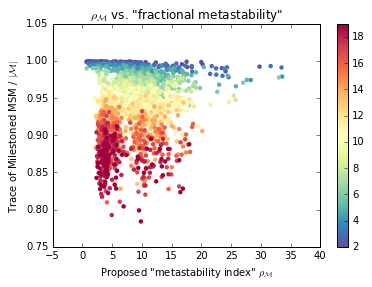

In [34]:
results = []
Ms = range(2,20) # various n_milestones
n_samples = 100 # number of samples at for each n_milestones
for M in Ms:
    result = sample_random_milestone_sets(M,n_states=100,n_samples=n_samples)
    results.append(result)
    
# coloring by the number of milestones
colors = np.zeros(len(Ms)*n_samples)
for i in range(len(Ms)):
    colors[i*n_samples:(i+1)*n_samples] = Ms[i]
metastability_indices = np.hstack([r[1] for r in results])
msms = []
for r in results:
    msms += r[0]
msm_metastability = [np.trace(msm.transition_matrix) for msm in msms]

plt.scatter(metastability_indices,msm_metastability,c=colors,linewidths=0,cmap='Spectral_r')
plt.xlabel(r'Proposed "metastability index" $\rho_\mathcal{M}$')
plt.ylabel('Trace of Milestoned MSM')
plt.title(r'$\rho_\mathcal{M}$ vs. metastability')
plt.colorbar()

plt.figure()

plt.scatter(metastability_indices,msm_metastability/colors,c=colors,linewidths=0,cmap='Spectral_r')
plt.xlabel(r'Proposed "metastability index" $\rho_\mathcal{M}$')
plt.ylabel(r'Trace of Milestoned MSM / $|\mathcal{M}|$')
plt.title(r'$\rho_\mathcal{M}$ vs. "fractional metastability"')
plt.colorbar()

In [35]:
# colors array contain
colors[np.argmin(metastability_indices)]

2.0

In [36]:
np.min(metastability_indices)

0.67790343627664196

### 4.4. Smaller problem instance, full range of `n_milestones`

In [ ]:
# let's do this deterministically. If there are 10 candidate milestones, then there are 1022 possible milestone sets

In [37]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=10,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

kmeans iterations:  22% ( 225/1000) [######                        ] eta 00:11 /11-05-16 09:20:45 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3] INFO     Cluster centers converged after 226 steps.
getting output of MiniBatchKmeansClustering: 100% (20/20) [########] eta 00:00 |

In [50]:
gamma = form_gamma(dtrajs)

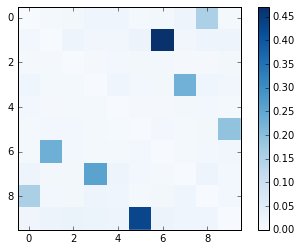

In [59]:
plt.imshow(gamma,interpolation='none',cmap='Blues')
plt.colorbar()

In [83]:
metastability_indices = []
msms = []
n_milestones = []

import itertools
for bitmask in itertools.product([0,1],repeat=10):
    if np.sum(bitmask) == 0 or np.sum(bitmask) == len(bitmask):
        continue 
    
    try: # sometimes msm estimation fails here
        milestones = np.arange(10)[np.array(bitmask,dtype=bool)]
        
        dtrajs_m = milestone(dtrajs,milestones)
        msm_1 = pyemma.msm.estimate_markov_model(dtrajs_m,lag=lag)

        msms.append(msm_1)
        metastability_indices.append(metastability_index(gamma,milestones))
        n_milestones.append(np.sum(bitmask))
    except:
        continue

msm_metastability = [np.trace(msm.transition_matrix) for msm in msms]

In [84]:
len(msm_metastability),len(metastability_indices),len(n_milestones)

(1021, 1021, 1021)

In [85]:
msm_metastability = [np.trace(msm.transition_matrix) for msm in msms]
len(msm_metastability)

1021

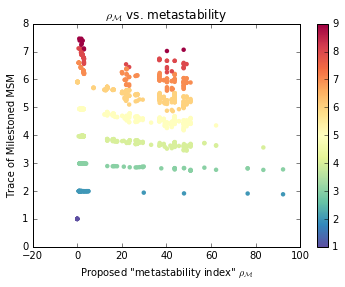

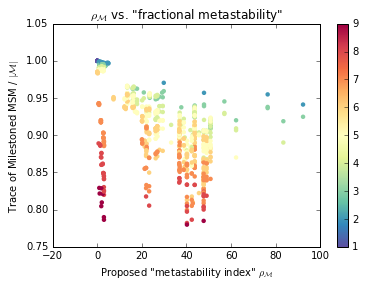

In [86]:
plt.scatter(metastability_indices,msm_metastability,c=n_milestones,linewidths=0,cmap='Spectral_r')
plt.xlabel(r'Proposed "metastability index" $\rho_\mathcal{M}$')
plt.ylabel('Trace of Milestoned MSM')
plt.title(r'$\rho_\mathcal{M}$ vs. metastability')
plt.colorbar()

plt.figure()

plt.scatter(metastability_indices,msm_metastability/np.array(n_milestones),c=n_milestones,linewidths=0,cmap='Spectral_r')
plt.xlabel(r'Proposed "metastability index" $\rho_\mathcal{M}$')
plt.ylabel(r'Trace of Milestoned MSM / $|\mathcal{M}|$')
plt.title(r'$\rho_\mathcal{M}$ vs. "fractional metastability"')
plt.colorbar()

In [87]:
n_milestones[np.argmin(metastability_indices)]

1